In [4]:
cd /home/c01muya/vae-disentanglement/disent-vaes/

[Errno 2] No such file or directory: '/home/c01muya/vae-disentanglement/disent-vaes/'
/media/DATA/Saarbrucken/EDA_Research/thesis_code


In [5]:
import yaml
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T

from models import *
from experiment import VAEExperiment
from models import BetaVAE_Vanilla
import seaborn as sns

from continum_loader import ContinumDataset
from three_shapes_loader import ThreeShapesDataset

from torch.utils.data import DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib.pyplot import figure

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})


ModuleNotFoundError: No module named 'torch'

## Load the VAE Model

In [6]:
curr_dev = torch.device("cuda:1")

def load_vae_model(config_path, checkpoint_path, curr_dev):
        
    bvae_config = yaml.safe_load(open(config_path,'r'))
    bvae_model = BetaVAE(**bvae_config['model_params'])
    bvae_experiment = VAEExperiment.load_from_checkpoint(
        checkpoint_path,
        map_location=curr_dev,
        vae_model=bvae_model, 
        params=bvae_config['exp_params'])

    bvae_experiment = bvae_experiment.to(curr_dev)

    return bvae_experiment

model_for_shapes = load_vae_model(
    config_path="./configs/betavae_3shapes.yaml", 
    checkpoint_path="./logs/BetaVAE_Loss_H_3shapes_b1/version_2/checkpoints/epoch=99-step=6199.ckpt",, 
    curr_dev=curr_dev)

model_for_noisy_shapes = load_vae_model(
    config_path="./configs/n3shapes.yaml", 
    checkpoint_path="./logs/n3shapes_b1_loss_h/version_0/checkpoints/epoch=99-step=6199.ckpt",, 
    curr_dev=curr_dev)

model_for_noisy_shape_l2 = load_vae_model(
    config_path="./configs/n3shapes_l2.yaml", 
    checkpoint_path="./logs/n3shapes_l2_b1_loss_h/version_0/checkpoints/epoch=99-step=6199.ckpt",, 
    curr_dev=curr_dev)

## Visualize a single sample

-0.0019728143 0.9998234


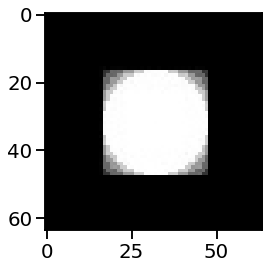

In [70]:

# samples = model_for_shapes.model.sample(36, curr_dev)

# these samples may have -ve values
# one_sample_numpy = samples[0].detach().cpu().numpy()
# print(np.min(one_sample_numpy),np.max(one_sample_numpy))

# convert from pytorch to matplotlib format
# one_sample_numpy = one_sample_numpy.transpose(1,2,0)
# plt.imshow(one_sample_numpy, cmap='gray', vmin=0, vmax=1.0)

## Get latent code for different shapes

In [71]:
pwd

'/home/c01muya/vae-disentanglement/disent-vaes'

In [2]:
def get_latent_activations(dataset, vae_model):

    batch_size = 32
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle = True, drop_last=True)
    latent_act_dict = defaultdict(list)

    for x_batch, label_batch in tqdm(loader):

        # First we encode this batch
        x_batch = x_batch.to(curr_dev)
        mu_batch, log_var_batch = vae_model.model.encode(x_batch)

        # Then, we get \mu and \sigma for this batch
        mu_batch = mu_batch.detach().cpu().numpy()
        log_var_batch = log_var_batch.detach().cpu().numpy()

        # and labels
        label_batch = label_batch.cpu().numpy()

        # using labels, we place all \mu's belonging to same class together
        for b in range(batch_size):

            # sort into related

            label_of_this_x = int(label_batch[b].squeeze())
            
            print(mu_batch[b].ndim)
            
            latent_act_dict[label_of_this_x].append( mu_batch[b].item() )
            
            return latent_act_dict
    
    return latent_act_dict

In [3]:
dataset = ThreeShapesDataset(root="../datasets/ThreeShapesData/", split="train")
noisy_dataset = ThreeShapesDataset(root="../datasets/ThreeShapesDataNoisy/", split="train")

# acts_shapes = get_latent_activations(dataset, model_for_shapes)
# acts_for_noisy_shapes = get_latent_activations(noisy_dataset, model_for_noisy_shapes)

acts_for_noisy_shapes_l2 = get_latent_activations(noisy_dataset, model_for_noisy_shapes_l2)

NameError: name 'ThreeShapesDataset' is not defined

## Plot histogram of latent code unit

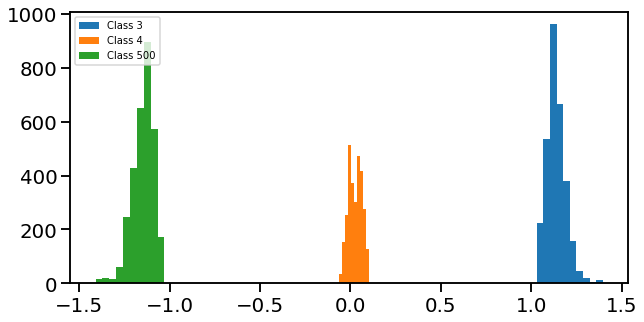

In [10]:
figure(figsize=(10,5))

for k in acts_shapes.keys():
    plt.hist(acts_shapes[k], label=f"Class {k}")

plt.legend(prop={'size': 10},loc='upper left')

In [ ]:
figure(figsize=(10,5))

for k in acts_for_noisy_shapes.keys():
    plt.hist(acts_for_noisy_shapes[k], label=f"Class {k}")

plt.legend(prop={'size': 10},loc='upper left')

In [11]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        print(img.dtype)
        img = T.to_pil_image(img,mode='RGB')
        axs[0, i].imshow(np.asarray(img),cmap='gray',vmin=0.0,vmax=1.0)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.float32


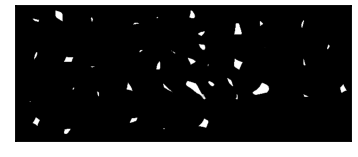

In [30]:
grid_samples = vutils.make_grid(samples.cpu().data, normalize=True, nrow=10, value_range=(0,1.0))
show(grid_samples)